In [1]:
# Connecting to Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Installing the required libraries
!pip install sentencepiece optuna
!pip install transformers datasets
!pip install torch huggingface_hub 
!pip install rouge.score nltk py7zr
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 13.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 102.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 85.4 MB/s eta 0:00:0

In [3]:
# Importing the necessary libraries
import torch
import numpy as np
import pandas as pd
import datasets
import transformers
import nltk
import optuna
import os
from collections import defaultdict
from scipy.spatial.distance import cosine

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
!apt-get update -qq && apt-get install -y -qq locales
!locale-gen en_US.UTF-8
!update-locale LANG=en_US.UTF-8
!export LC_ALL=en_US.UTF-8
!export LANG=en_US.UTF-8
!pip install --no-cache-dir https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.1.0/en_core_web_sm-3.1.0.tar.gz
import spacy

# Load pre-trained word embeddings
nlp = spacy.load("en_core_web_sm")


Generating locales (this might take a while)...
  en_US.UTF-8... done
Generation complete.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 218.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 659.5/659.5 kB 246.7 MB/s eta 0:00:00
  Created wheel for en-core-web-sm: filename=en_core_web_sm-3.1.0-py3-none-any.whl size=13622652 sha256=f5cb9f0736299246e465f3387d1a032e3e2f3a65a36163b2dbe999c8cd2c27bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-vrm0n989/wheels/7d/6e/48/3d557772e2dba160f9e80683da52497090100cde2173ef5e34
Successfully built en-core-web-sm
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.1
    Uninstalling wasabi-1.1.1:
      Succe

In [5]:
# Function to extract aspect sentences
def extract_aspect_sentences(document, aspects, threshold=0.1):
    aspect_sentences = defaultdict(list)
    aspect_sentences_combined = []

    doc = nlp(document)

    for sent in doc.sents:
        for aspect_name, aspect in aspects.items():
            if isinstance(aspect, str):
                for ent in sent.ents:
                    if ent.label_.lower() == aspect:
                        aspect_sentences[aspect_name].append(sent.text)
            else:
                sent_embedding = nlp(sent.text).vector
                similarity = 1 - cosine(aspect, sent_embedding)
                if similarity > threshold:
                    aspect_sentences[aspect_name].append(sent.text)

    # # Handling NER aspects
    # for sent in doc.sents:
    #     for ent in sent.ents:
    #         aspect = ent.label_.lower()
    #         if aspect in aspects:
    #             aspect_sentences[aspect].append(sent.text)

    # # Handling vector aspects
    # for sent in doc.sents:
    #     for aspect_name, aspect_vector in aspects.items():
    #         if not isinstance(aspect_vector, str):
    #             sent_embedding = nlp(sent.text).vector
    #             similarity = 1 - cosine(aspect_vector, sent_embedding)
    #             if similarity > threshold:
    #                 aspect_sentences[aspect_name].append(sent.text)


    for aspect_name in aspects.keys():
        if aspect_sentences[aspect_name]:
            aspect_sentences_combined.append(" ".join(aspect_sentences[aspect_name]))
        else:
            aspect_sentences_combined.append(f"No information found related to the aspect '{aspect_name}' in the document.")

    return " ".join(aspect_sentences_combined)


# Define the aspects you're interested in

military_weapons_aspect = nlp("military weapons").vector
criminal_activity_aspect = nlp("criminal activity").vector
war_casualties = nlp("war casualties").vector
law_enforcement = nlp("law enforcement").vector



aspect_mapping = {
    "location": "gpe",
    "person": "person",
    "date": "date",
    "organization": "org",

    "law_enforcement": law_enforcement,
    "criminal activity": criminal_activity_aspect,
    "war_casualties": war_casualties,
    "military weapons" : military_weapons_aspect
}




In [6]:

# Specifying parameters

LR_MIN = 3e-5
LR_CEIL = 0.01
WD_MIN = 2e-5
WD_CEIL = 0.01
MIN_EPOCHS = 6
MAX_EPOCHS = 12
MIN_BATCH_SIZE = 4
MAX_BATCH_SIZE = 6
NUM_TRIALS = 1
WARMUP_RATIO_MIN = 0.05
WARMUP_RATIO_MAX = 0.1
SAVE_DIR = 'opt-test'
ASPECT_MODEL_NAME = 't5-base'
MAX_INPUT = 512
MAX_TARGET = 250

# Selecting the first 2000 rows
dataset_path = 'gdrive/My Drive/fyp/'
data = pd.read_csv(dataset_path + 'xsum.csv', encoding='latin-1')
data = data[0:2000]

metric = datasets.load_metric('rouge')
data

def print_custom(text):
    print('\n')
    print(text)
    print('-'*100)

<ipython-input-6-34c6927714ff>:24: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric('rouge')


In [7]:
# Loading tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(ASPECT_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [8]:
# Preprocessing the data
prefix = "summarize: "
def preprocess_data(data_to_process):
    #get the document text
    
    inputs = [prefix + doc for doc in data_to_process["document"]]
  
    #tokenize text
    model_inputs = tokenizer(inputs,  max_length=MAX_INPUT, padding='max_length', truncation=True)

    #tokenize labels
    with tokenizer.as_target_tokenizer():
        targets = tokenizer(data_to_process['summary'], max_length=MAX_TARGET, padding='max_length', truncation=True)
        
    model_inputs['labels'] = targets['input_ids']
    return model_inputs

In [9]:
#  Perform a train test split of 80:20 ratio on the dataset
train_dataset = data[:int(len(data)*0.7)]
test_dataset = data[int(len(data)*0.7):int(len(data)*0.85)]
validation_dataset = data[int(len(data)*0.85):]

# Creating the dataset dictionary
data = datasets.DatasetDict({ 'train': datasets.Dataset.from_pandas(train_dataset), 
                              'test': datasets.Dataset.from_pandas(test_dataset),
                              'validation': datasets.Dataset.from_pandas(train_dataset)})

In [10]:
# Preprocessing data
tokenize_data = data.map(preprocess_data, batched = True, remove_columns=['document', 'summary'])

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

In [11]:
#sample the data
train_sample = tokenize_data['train'].shuffle(seed=123).select(range(1000))
validation_sample = tokenize_data['validation'].shuffle(seed=123).select(range(300))
test_sample = tokenize_data['test'].shuffle(seed=123).select(range(200))
     
# Updating tokenize_data dictionary
tokenize_data['train'] = train_sample
tokenize_data['validation'] = validation_sample
tokenize_data['test'] = test_sample

tokenize_data

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 300
    })
})

In [12]:
#loading the model
model = transformers.AutoModelForSeq2SeqLM.from_pretrained(ASPECT_MODEL_NAME)

batch_size = 1

#data_collator to create batches
data_collator = transformers.DataCollatorForSeq2Seq(tokenizer, model=model)

In [13]:
def compute_rouge(pred):
    predictions, labels = pred
    # Decode the predictions
    decode_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Decode labels
    decode_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute results
    res = metric.compute(predictions=decode_predictions, references=decode_labels, use_stemmer=True)
    res = {key: value.mid.fmeasure * 100 for key, value in res.items()}

    # Define weights for each ROUGE score
    weights = {'rouge1': 0.5, 'rouge2': 0.3, 'rougeL': 0.2}

    # Compute the weighted average of the rouge scores
    weighted_avg_rouge = sum(res[key] * weight for key, weight in weights.items()) / sum(weights.values())
    res['weighted_avg_rouge'] = round(weighted_avg_rouge, 4)

    # Compute the average length of generated summaries
    pred_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    res['avg_gen_len'] = np.mean(pred_lens)

    return {k: round(v, 4) for k, v in res.items()}


In [14]:
# Create the training arguments
args = transformers.Seq2SeqTrainingArguments(
    'aspect-based-summary',
    evaluation_strategy='epoch',
    learning_rate=0.001,
    per_device_train_batch_size=1,
    per_device_eval_batch_size= 1, 
    gradient_accumulation_steps=2,
    weight_decay=0.1,
    save_total_limit=2,
    warmup_ratio=0.1,
    num_train_epochs=7,
    predict_with_generate=True,
    eval_accumulation_steps=1,
    fp16=True
  )

# Create the trainer
trainer = transformers.Seq2SeqTrainer(
    model, 
    args,
    train_dataset=tokenize_data['train'],
    eval_dataset=tokenize_data['validation'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_rouge
)


In [15]:
# Clearing the cuda memory
import torch
torch.cuda.empty_cache()

In [16]:

# Train the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Weighted Avg Rouge,Avg Gen Len
1,0.912300,0.230005,29.947100,9.990100,24.531700,24.556100,22.876900,18.586700
2,0.274800,0.143818,38.302300,19.360300,33.223700,33.276400,31.604000,18.590000
3,0.177300,0.074992,47.651100,32.626800,43.402900,43.368100,42.294200,18.786700
4,0.107200,0.037700,59.046200,48.358600,56.331300,56.256600,55.297000,18.763300
5,0.055100,0.013345,75.528300,71.707200,74.796700,74.821000,74.235600,18.773300
6,0.026600,0.004745,79.681700,78.241400,79.643700,79.591400,79.242000,18.790000
7,0.013100,0.002626,80.205500,78.966300,80.129500,80.118100,79.818500,18.776700


TrainOutput(global_step=3500, training_loss=0.22375908075060164, metrics={'train_runtime': 2092.1371, 'train_samples_per_second': 3.346, 'train_steps_per_second': 1.673, 'total_flos': 4262705233920000.0, 'train_loss': 0.22375908075060164, 'epoch': 7.0})

In [17]:
# Clearing the cuda memory
torch.cuda.empty_cache()

In [18]:
# Evaluate the model
metrics = trainer.evaluate()



Printing the metrics
----------------------------------------------------------------------------------------------------
{'eval_loss': 0.0026263988111168146, 'eval_rouge1': 80.2055, 'eval_rouge2': 78.9663, 'eval_rougeL': 80.1295, 'eval_rougeLsum': 80.1181, 'eval_weighted_avg_rouge': 79.8185, 'eval_avg_gen_len': 18.7767, 'eval_runtime': 113.7368, 'eval_samples_per_second': 2.638, 'eval_steps_per_second': 2.638, 'epoch': 7.0}


ROUGE Scores by Epoch for Text Summarization
----------------------------------------------------------------------------------------------------


<Axes: xlabel='epoch'>

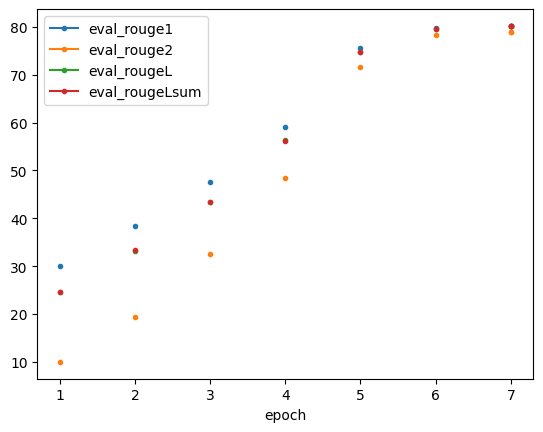

In [19]:
# Print the metrics
print_custom('Printing the metrics')
print(metrics)

df = pd.DataFrame(trainer.state.log_history)

# Creating a line graph for the metrics
print_custom('ROUGE Scores by Epoch for Text Summarization')
df.plot(x='epoch', y=['eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum'], style='.-')



Validation Loss by Epoch for Text Summarization
----------------------------------------------------------------------------------------------------


<Axes: xlabel='epoch'>

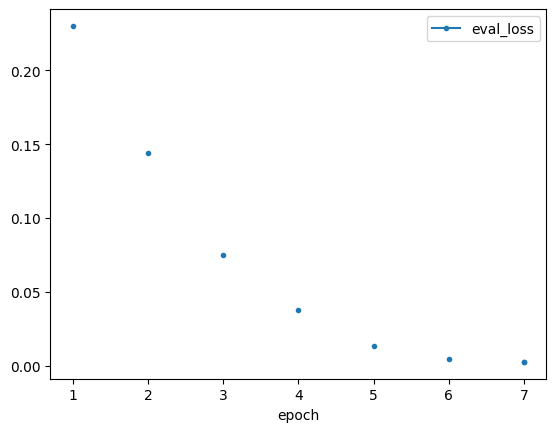

In [20]:
# Creating the validation loss graph 
print_custom('Validation Loss by Epoch for Text Summarization')
df.plot(x='epoch', y=['eval_loss'], style='.-')

<Axes: title={'center': 'Evolution of ROUGE Scores and Weighted Average ROUGE by Epoch'}, xlabel='epoch'>

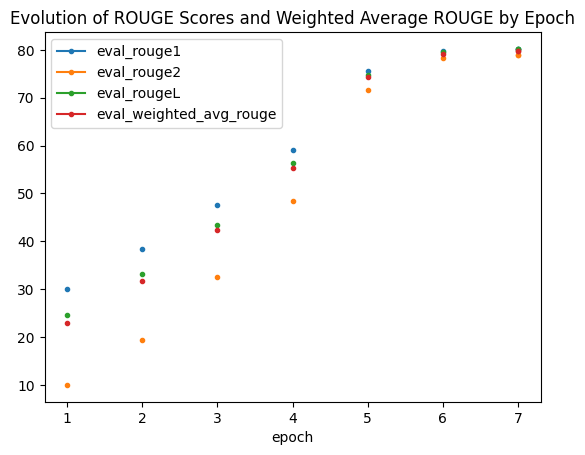

In [21]:
df.plot(x='epoch', y=['eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_weighted_avg_rouge'], style='.-', title="Evolution of ROUGE Scores and Weighted Average ROUGE by Epoch")


<Axes: title={'center': 'Comparison of Training and Evaluation Losses by Epoch'}, xlabel='epoch'>

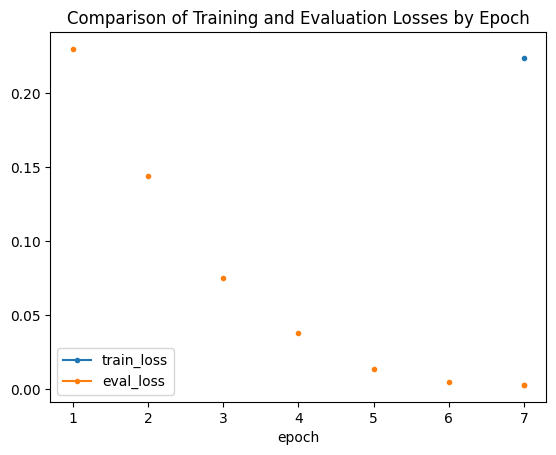

In [22]:
df.plot(x='epoch', y=['train_loss', 'eval_loss'], style='.-', title="Comparison of Training and Evaluation Losses by Epoch")


<Axes: title={'center': 'Learning Rate Schedule by Training Step'}, xlabel='step'>

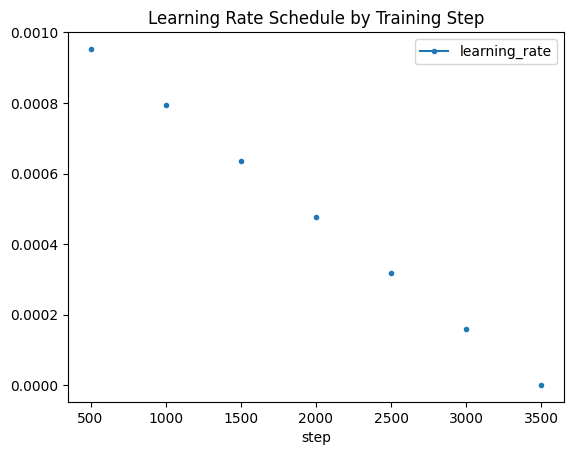

In [23]:
df.plot(x='step', y=['learning_rate'], style='.-', title="Learning Rate Schedule by Training Step")


In [51]:
import os
import re


def capitalize_sentences(summary):
    # Capitalize the first letter of each sentence
    summary = re.sub(r'(?<=\.\s)(\w)', lambda x: x.group(1).upper(), summary)

    # Remove any leading punctuation or whitespace
    summary = re.sub(r'^[^a-zA-Z]*', '', summary)

    # Ensure the first character is uppercase
    summary = summary[0].upper() + summary[1:]

    return summary


def aspect_based_summarization(document, aspect_name):
    aspect_sentences = extract_aspect_sentences(document, {aspect_name: aspect_mapping[aspect_name]})

    if f"No information found related to the aspect '{aspect_name}'" in aspect_sentences:
        return aspect_sentences

    aspect_inputs = tokenizer.encode(aspect_sentences, return_tensors='pt', max_length=MAX_INPUT, truncation=True)

    # Ensure both model and inputs are on the same device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    aspect_inputs = aspect_inputs.to(device)

    aspect_outputs = model.generate(aspect_inputs, max_length=450, min_length=50, length_penalty=1.5, num_beams=5, early_stopping=True, no_repeat_ngram_size=2)

    aspect_based_summary = tokenizer.decode(aspect_outputs[0], skip_special_tokens=True)

    aspect_based_summary = capitalize_sentences(aspect_based_summary)

    # aspect_based_summary = remove_incomplete_sentences(aspect_based_summary)

    return aspect_based_summary


document = """ 
More than 20,000 Russian soldiers have been killed in fighting in Ukraine since December, the US estimates.

A further 80,000 have been wounded, National Security Council spokesman John Kirby said, citing newly declassified intelligence.

Half of the dead are from the Wagner mercenary company, who have been attacking the eastern Bakhmut city.

Russia has been trying to take the small city since last year in a grinding war of attrition.

Moscow currently holds most of Bakhmut, but Ukrainian troops still control a small portion of the city in the west. The fierce battle has taken on huge symbolic importance for both sides.

Ukrainian officials have also said they are using the battle to kill as many of Russia's troops as possible and wear down its reserves.

"Russia's attempt at an offensive in the Donbas [region] largely through Bakhmut has failed," Mr Kirby told reporters. "Russia has been unable to seize any real strategic and significant territory.

"We estimate that Russia has suffered more than 100,000 casualties, including over 20,000 killed in action," he added.

The toll in Bakhmut accounts for losses since the start of December, according to the US figures.

"The bottom line is that Russia's attempted offensive has backfired after months of fighting and extraordinary losses," Mr Kirby said.

He added he was not giving estimates of Ukrainian casualties because "they are the victims here. Russia is the aggressor".

The BBC is unable to independently verify the figures given and Moscow has not commented.
The capture of the city would bring Russia slightly closer to its goal of controlling the whole of Donetsk region, one of four regions in eastern and southern Ukraine annexed by Russia last September following referendums widely condemned outside Russia as a sham.

Analysts say Bakhmut has little strategic value, but has become a focal point for Russian commanders, who have struggled to deliver any positive news to the Kremlin.

The Wagner mercenary group - which widely uses convicts and has become notorious for its often inhumane methods - has taken centre stage in the Russian assault on Bakhmut.

Its leader, Yevgeny Prigozhin, has staked his reputation, and that of his private army, on seizing the city.

But he recently threatened to pull his troops out of Bakhmut.

In a rare in-depth interview to a prominent Russian war blogger, he vowed to withdraw Wagner fighters if they were not provided with much-needed ammunition by the Russian defence ministry.

Wagner fighters could be redeployed to Mali, he warned.

He has often clashed with Russia's defence ministry during the war, accusing officials of not providing his fighters with enough support.

Mr Prigozhin also called upon the Russian media and military leadership to "stop lying to the Russian population" ahead of an expected Ukrainian spring counteroffensive.

"We need to stop lying to the Russian population, telling them everything is all right," he said.

He praised the Ukrainian military's "good, correct military operations" and command.

A top Ukrainian general said on Monday that counterattacks had ousted Russian forces from some positions in Bakhmut, but the situation remained "difficult".

New Russian units, including paratroopers and fighters from Wagner, are being "constantly thrown into battle" despite taking heavy losses, Gen Oleksandr Syrskyi, the commander of Ukraine's ground forces, said on Telegram.

"But the enemy is unable to take control of the city," he said.

"""

# Choose the aspect you want to summarize
aspect = "date"
# Generate the summary for the chosen aspect
aspect_specific_summary = aspect_based_summarization(document, aspect)

print("Aspect-based summary:")

print(aspect_specific_summary)     


Aspect-based summary:
A former Soviet republic, Bakhmut, has been taken hostage in Ukraine, after a month of intense anti-austerity fighting between US troops and security forces, president Alex Kirby has said, leading to "devastatingly long" losses.


In [52]:
# Save the model
drive_path_to_save_model = 'gdrive/My Drive/fyp/AspectSummarizationModels/' + ASPECT_MODEL_NAME + '-aspect-model'

# Ensure the model directory exists, and create it if not
model_directory = os.path.dirname(drive_path_to_save_model)
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

# Save the model
model.save_pretrained(drive_path_to_save_model)

# Save the tokenizer
drive_path_to_save_tokenizer = 'gdrive/My Drive/fyp/AspectSummarizationModels/' + ASPECT_MODEL_NAME + '-aspect-tokenizer'

# Ensure the tokenizer directory exists, and create it if not
tokenizer_directory = os.path.dirname(drive_path_to_save_tokenizer)
if not os.path.exists(tokenizer_directory):
    os.makedirs(tokenizer_directory)

# Save the tokenizer
tokenizer.save_pretrained(drive_path_to_save_tokenizer)

# Load the model
drive_path_to_load_model = 'gdrive/My Drive/fyp/AspectSummarizationModels/' + ASPECT_MODEL_NAME + '-aspect-model'
loaded_model = transformers.AutoModelForSeq2SeqLM.from_pretrained(drive_path_to_load_model)

# Load the tokenizer
drive_path_to_load_tokenizer = 'gdrive/My Drive/fyp/AspectSummarizationModels/' + ASPECT_MODEL_NAME + '-aspect-tokenizer'
loaded_tokenizer = transformers.AutoTokenizer.from_pretrained(drive_path_to_load_tokenizer)